In [1]:
import torch
from modeling_layoutlm import LayoutLMForTokenClassification
from transformers import (
    BertConfig,
    BertTokenizer,
)
from utils_docvqa import (
    read_docvqa_examples,
    convert_examples_to_features)
from torch.utils.data import DataLoader, SequentialSampler, TensorDataset
from transformers.data.processors.squad import SquadResult
from tqdm import tqdm
import numpy as np
from tabulate import tabulate

/Users/hari/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_path = 'test_image.jpeg'

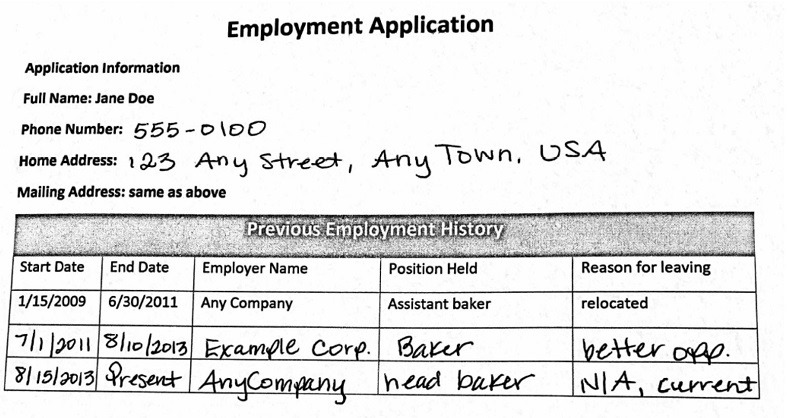

In [3]:
from IPython.display import Image
Image(filename=image_path)

In [4]:
from bounding_box import save_bounding_boxes
SAMPLE_DATA = save_bounding_boxes(
    image_path=image_path,
    questions=[
        "What is phone number?",
        "What is start date and end date of AnyCompany?",
        "What is reason for leaving assistant baker position?"
    ]
)

In [5]:
MODEL_FOLDER = "./models/"
LABELS = ["start","end"]
pad_token_label_id=-100
labels = ["start","end"]
max_seq_length = 512
max_query_length = 64
doc_stride = 512 ## bigger the stride, more the tries for a answers (for big stride, gives the most similar answer w.r.t question)

In [6]:
# device = torch.device("cuda:0")
device = torch.device("cpu")
# torch.cuda.set_device(device)
model_class = LayoutLMForTokenClassification
config_class = BertConfig
tokenizer_class = BertTokenizer
config = config_class.from_pretrained(MODEL_FOLDER,num_labels=2,cache_dir=None)
model = model_class.from_pretrained(MODEL_FOLDER)
tokenizer = tokenizer_class.from_pretrained(MODEL_FOLDER,do_lower_case=True)

In [7]:
examples = read_docvqa_examples(SAMPLE_DATA, is_training=False)

In [8]:
features = convert_examples_to_features(
            examples=examples,
            label_list=labels,
            tokenizer=tokenizer,
            max_seq_length=max_seq_length,
            doc_stride=doc_stride,
            max_query_length=max_query_length,
            is_training=False,
            pad_token_label_id=pad_token_label_id)

In [9]:
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_bboxes = torch.tensor([f.boxes for f in features], dtype=torch.long)
all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)

eval_dataset = TensorDataset(
        all_input_ids, all_input_mask, all_segment_ids,all_bboxes,all_example_index)
eval_batch_size = 1
eval_sampler = (
        SequentialSampler(eval_dataset))

eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size
    )

In [10]:
model.to(device)
all_results = []
table_data = []

def to_list(tensor):
    return tensor.detach().cpu().tolist()

for batch in tqdm(eval_dataloader, desc="Evaluating"):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        inputs = {
            "input_ids": batch[0],
            "attention_mask": batch[1],
        }
        inputs["bbox"] = batch[3]
        inputs["token_type_ids"] = (batch[2])
        outputs = model(**inputs)
    example_indices = batch[4]

    for i, example_index in enumerate(example_indices):
        eval_feature = features[example_index.item()]
        unique_id = int(eval_feature.unique_id)

        output = [to_list(output[i]) for output in outputs]

        start_logits, end_logits = output
        result = SquadResult(unique_id, start_logits, end_logits)
        all_results.append(result)
predictions_json = {}
assert len(all_results)==len(features)
for i in range(len(all_results)):
    start_index = np.argmax(all_results[i].start_logits)
    end_index = np.argmax(all_results[i].end_logits)
    pred_answer = features[i].tokens[start_index:end_index+1]
    pred_answer = ' '.join([x for x in pred_answer])
    pred_text = pred_answer.replace(' ##', '')
    question = features[i].tokens[1:features[i].tokens.index('[SEP]')]
    question_text = ' '.join([x for x in question])
    question_text = question_text.replace(' ##', '')
    table_data.append([question_text, pred_text])
    # print(question_text)
    # print(pred_text) 


headers = ["Question", "Answer"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))

Evaluating: 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]

+-------------------------------------------------------+---------------+
| Question                                              | Answer        |
+=======================================================+===============+
| what is phone number ?                                | 555 - o \ o0  |
+-------------------------------------------------------+---------------+
| what is start date and end date of anycompany ?       | 6 / 30 / 2011 |
+-------------------------------------------------------+---------------+
| what is reason for leaving assistant baker position ? | relocated     |
+-------------------------------------------------------+---------------+
